## Описание проекта "Прогнозирование температуры плавления стали"
Задача:

Для оптимизации производственных расходов металлургического комбината ООО «Так закаляем сталь», а именно уменьшение потребления электроэнергии на этапе обработки стали нужно построить модель, которая предскажет температуру стали.

Данные:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Условия задачи:

Для оценки качества моделей метрику используем MSE: MSE должна быть <=6.8

План проекта:

- Разбор производственного процесса;
- Изучение данных;
- Исследовательский анализ данных;
- Подготовка данных для построения модели, генерация признаков, проверка на мультиколлинеарность;
- Построение и обучение моделей, выбор гиперпараметров;
- Корректировка признаков, обучение моделей;
- Тестирование и оценка эффективности модели;
- Выводы.

In [7]:
import pandas as pd #loading the necessary libraries
import numpy as np
import seaborn as sns
import os
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Производственный процесс

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Изучение данных

Посмотрим в каком виде к нам попали данные. Для этого загрузим по 5 строчек из каждого имеющегося датасета.

In [8]:
filenames = [_ for _ in os.listdir("/final_steel") if _.endswith(r'.csv')]#/datasets
for name in filenames:
    display(pd.read_csv("/final_steel/"+name,nrows = 5))

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '/final_steel'

Мы видим, что в данных присутствуют столбцы с информацией о времени. Загрузим данные полностью с предварительным преобразованием к временным типам.

In [3]:
data_arc = pd.read_csv('data_arc.csv', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой']) #/datasets/final_steel/  
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv', parse_dates = [f'Bulk {i}' for i in range(1,16)])
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv', parse_dates = ['Время замера'])
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv', parse_dates = [f'Wire {i}' for i in range(1,10)])



#data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой']) #/datasets/final_steel/  
#data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
#data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates = [f'Bulk {i}' for i in range(1,16)])
#data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
#data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates = ['Время замера'])
#data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
#data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates = [f'Wire {i}' for i in range(1,10)])

Данные загружены. Посмотрим их особенности, поищем аномалии, проверим на адекватность.

### Данные об электродах

In [9]:
def sum_info(df):
    """function that displays common information about data:
    5 first rows, general info, info about batches"""
    display(df.head())
    df.info()
    print(f'Номера партий: {df.key.unique()}')
    print(f'Количество партий: {df.key.nunique()}')

sum_info(data_arc)
data_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество партий: 3214


TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [5]:
def key_notin(df):
    """function that determines the numbers of batches 
    that do not appear in the dataset"""
    not_key = []
    for i in range(1,3242):
        if i not in df.key.unique():
            not_key.append(i)
    return not_key

print(f'Номера партий, которых нет в данных об электродах: {key_notin(data_arc)}')

Номера партий, которых нет в данных об электродах: [41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]


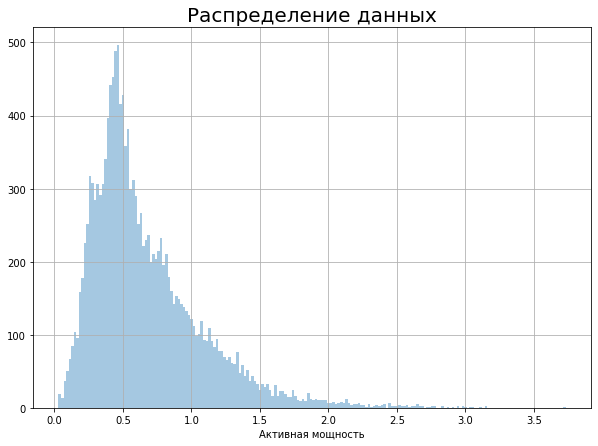

In [6]:
def dist_info(df, col):
    '''function that display the distribution of data
    input: df, column name'''
    plt.figure(figsize=[10, 7])
    sns.distplot(df[col], bins = 200, kde = False)
    plt.grid(True)
    plt.title('Распределение данных', fontsize = 20)
    plt.show()
    
dist_info(data_arc, 'Активная мощность')

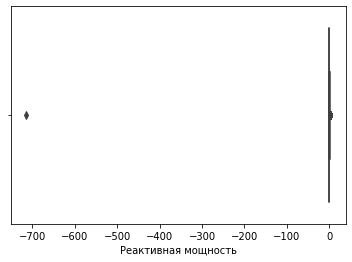

In [7]:
sns.boxplot(data_arc['Реактивная мощность'])
plt.show()

В данных о реактивной мощности видим аномальное значение. Рассмотрим эти аномальные явления подробнее.

In [8]:
display(data_arc[data_arc['Реактивная мощность'] < 0])
anomal_index = data_arc[data_arc['Реактивная мощность'] < 0].index.values
anomal_key = data_arc[data_arc['Реактивная мощность'] < 0].key.values
for ind in anomal_index:
    display(data_arc.loc[ind-1:ind+1])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Явная аномалия в данных(реактивная мощность в данной партии до и после этого замера выглядят нормально). Поскольку значение аномальное значение есть только в одной партии, удалим эту партию из датасета.

In [9]:
data_arc = data_arc.query('key not in @anomal_key')

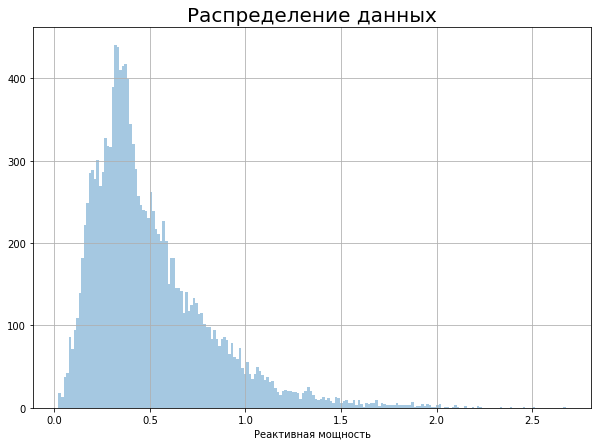

In [10]:
dist_info(data_arc, 'Реактивная мощность')

Проверим зависимость двух мощностей.

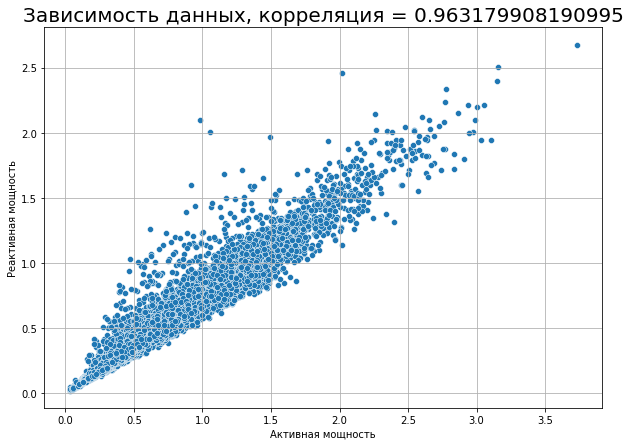

In [11]:
plt.figure(figsize=[10, 7])
sns.scatterplot(data_arc['Активная мощность'], data_arc['Реактивная мощность'])
plt.grid(True)
plt.title(f'Зависимость данных, корреляция = {data_arc["Активная мощность"].corr(data_arc["Реактивная мощность"])}', fontsize = 20)
plt.show()

Данные активной и реактивной мощности сильно коррелированы. В качества признака для модели можно будет взять либо одну активную мощность либо полную мощность вычистяемую по формуле:
$$ S = \sqrt{P^2 + Q^2}, $$
где $S$ - полная мощность, $P$ - активная мощность, $Q$ - реактивная мощность.

### Данные о подаче сыпучих материалов

In [12]:
sum_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество партий: 3129


In [ ]:
data_bulk.columns = ['_'.join(col.split()).lower() for col in data_bulk.columns]

In [13]:
print(f'Партии данных о которых нет в датасете: {key_notin(data_bulk)}')

Партии данных о которых нет в датасете: [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]


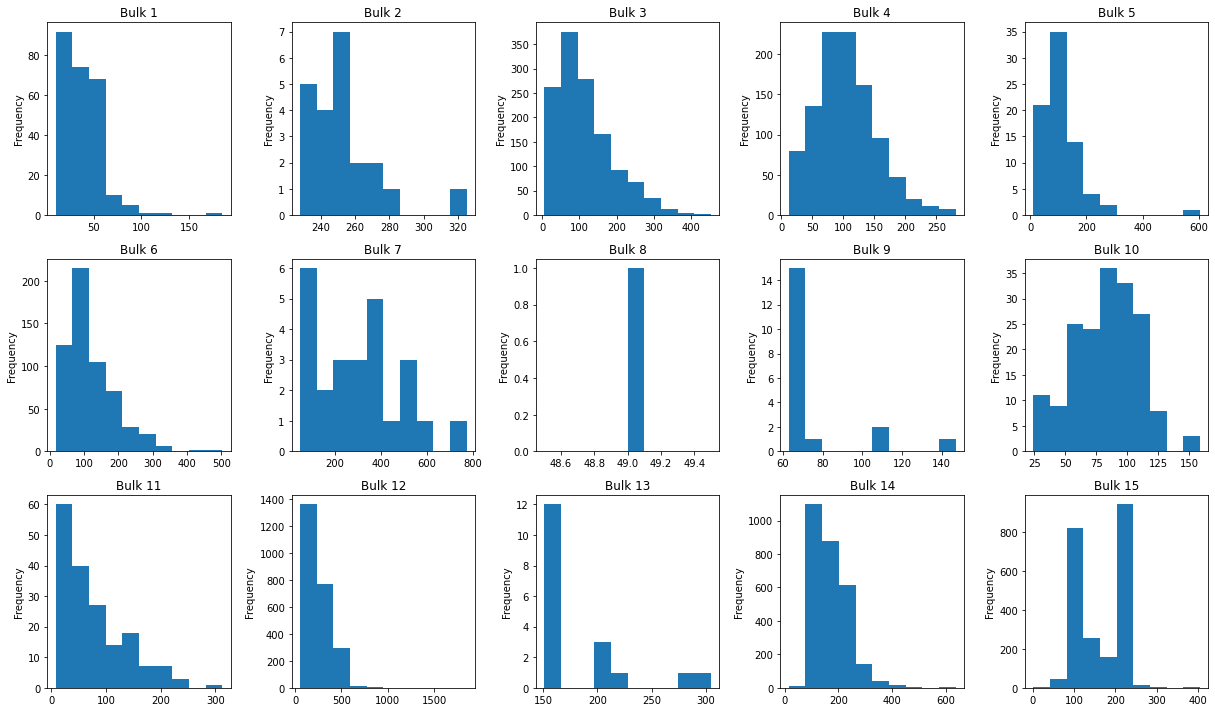

In [14]:
fig = plt.figure(figsize=(17,10))
for i, col in enumerate(data_bulk.columns[1:]):
    fig.add_subplot(3, 5, i+1)
    data_bulk[col].plot(kind = 'hist')  
    plt.title(col)
plt.tight_layout()
plt.show()

Аномалий не замечено. 

Пропущенные данные для какого-то материала означает то, что этот материал не подавался в данном номере партии. Можно заменить эти пропущенные данные на 0.

Поскольку (после замены) данные в таблице - целые числа, то заменим float на integer.

In [15]:
data_bulk = data_bulk.fillna(0).astype(int)
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152


In [16]:
sum_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
Номера партий: [   1   

In [17]:
print(f'Партии данных о которых нет в датасете: {key_notin(data_bulk_time)}')

Партии данных о которых нет в датасете: [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]


In [18]:
key_notin(data_bulk_time)==key_notin(data_bulk) #check if batches in data_bulk ana data_bulk_time are the same

True

### Данные о продувке сплава газом

In [19]:
sum_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество партий: 3239


In [20]:
print(f'Партии данных о которых нет в датасете: {key_notin(data_gas)}')

Партии данных о которых нет в датасете: [193, 259]


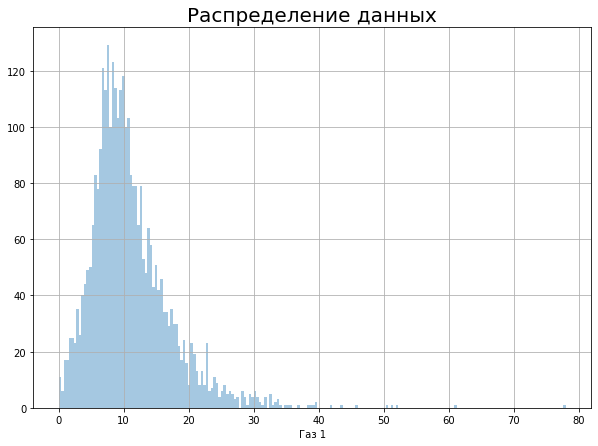

In [21]:
dist_info(data_gas, 'Газ 1')

### Данные о проволочных материалах

In [22]:
sum_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество партий: 3081


In [23]:
print(f'Партии данных о которых нет в датасете: {key_notin(data_wire)}')

Партии данных о которых нет в датасете: [41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207]


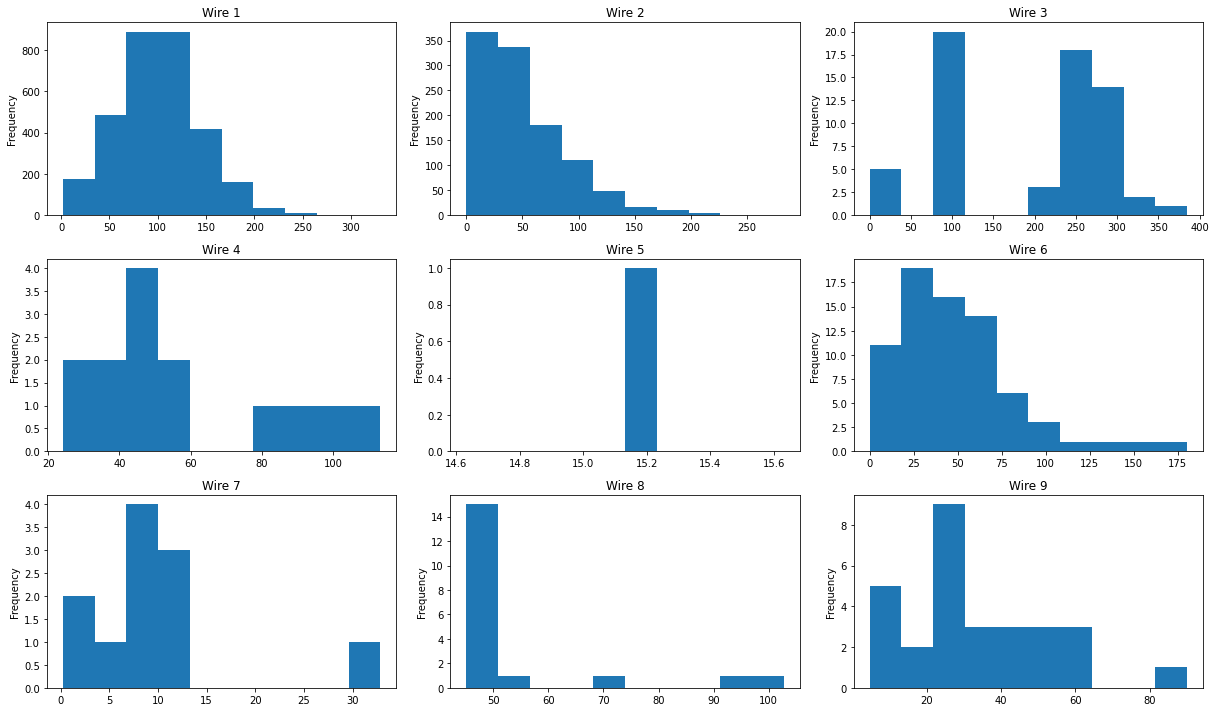

In [24]:
fig = plt.figure(figsize=(17,10))
for i, col in enumerate(data_wire.columns[1:]):
    fig.add_subplot(3, 3, i+1)
    data_wire[col].plot(kind = 'hist')  
    plt.title(col)
plt.tight_layout()
plt.show()

Аномалий не замечено.

Пропущенные данные для какого-то материала означает то, что этот материал не подавался в данном номере партии. Можно заменить эти пропущенные данные на 0.

In [25]:
data_wire = data_wire.fillna(0)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
sum_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество партий: 3081


In [27]:
key_notin(data_wire_time)==key_notin(data_wire)

True

### Результаты измерения температуры

In [28]:
sum_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество партий: 3216


count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

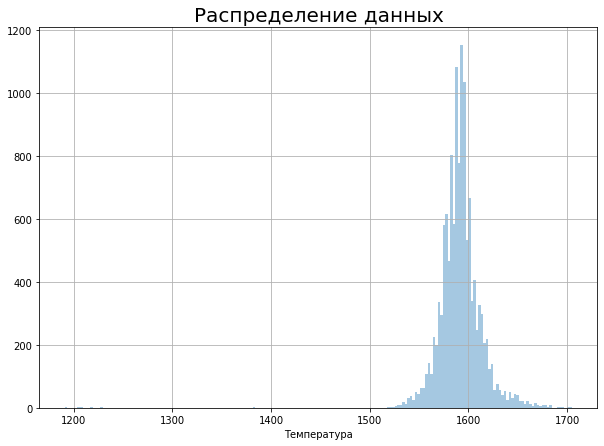

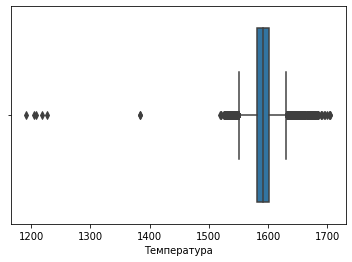

In [29]:
display(data_temp['Температура'].describe())
dist_info(data_temp, 'Температура')
sns.boxplot(data_temp['Температура'])
plt.show()

Температура плавления стали находится в диапазоне от 1350 до 1535°С. То что ниже 1350 - аномальные значения. Сделаем ограничение 1500 градусов, так как все остальные значения лежат правее этой границы, за исключением 1 выброса и рассмотрим эти данные подробнее.

In [30]:
keys_anomal = data_temp[data_temp['Температура']<1350].key
data_temp.query('key in @keys_anomal')

def custom_style(df):
    '''function that hightlight batches'''
    colors = ['orange', 'green']
    x = df.copy()
    factors = list(x['key'].unique())
    i = 0
    for factor in factors:
        style = f'background-color: {colors[i]}'
        x.loc[x['key'] == factor, :] = style
        i = not i
    return x

data_temp.query('key in @keys_anomal').style.apply(custom_style, axis=None)

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.000000
4351,867,2019-06-04 14:29:35,1575.000000
4352,867,2019-06-04 14:30:29,1576.000000
4353,867,2019-06-04 14:43:10,1571.000000
4354,867,2019-06-04 14:52:54,1600.000000
4355,867,2019-06-04 14:57:17,1599.000000
5978,1214,2019-06-16 05:32:00,1208.000000
5979,1214,2019-06-16 05:49:01,1608.000000
5980,1214,2019-06-16 05:51:28,1608.000000
5981,1214,2019-06-16 05:51:38,1608.000000


In [31]:
display(data_arc.query('key == 867'))
display(data_wire_time.query('key == 867'))
display(data_bulk_time.query('key == 867'))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
4028,867,2019-06-04 14:17:51,2019-06-04 14:20:06,0.470265,0.342909
4029,867,2019-06-04 14:33:04,2019-06-04 14:35:39,0.546894,0.401882
4030,867,2019-06-04 14:36:50,2019-06-04 14:37:49,0.217033,0.157679
4031,867,2019-06-04 14:39:23,2019-06-04 14:41:13,0.446139,0.383610
4032,867,2019-06-04 14:44:01,2019-06-04 14:47:10,0.815899,0.591709
4033,867,2019-06-04 14:48:06,2019-06-04 14:52:20,1.133725,0.781918
4034,867,2019-06-04 14:54:19,2019-06-04 14:55:26,0.278104,0.189851


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
813,867,2019-06-04 14:32:56,2019-06-04 14:43:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
832,867,NaT,NaT,2019-06-04 14:43:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-06-04 14:38:05,NaT,2019-06-04 14:38:05,2019-06-04 14:38:05


Аномальные данные появляются в начале замера. Возможно это какие-то сбои датчика перед началом измерения температуры в партии. Считаю, что можно удалить строку с этим замером и считать первоначальную температуру ту, которая получена при следующем замере. Судя по данным времени: сначала происходит первый нагрев, потом измеряется температура, если она аномальна - через короткий промежуток времени делается еще одно измерение температуры, если температура адекватна - то нагреваем еще, добавляем материалы, газ по надобности.

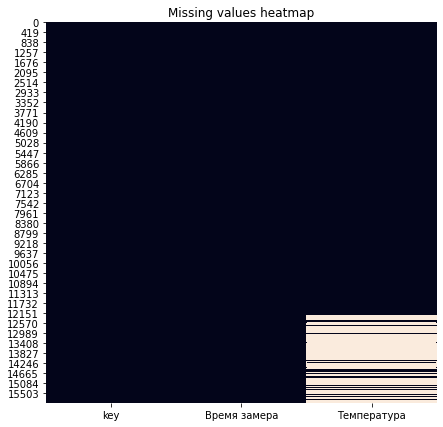

In [32]:
fig = plt.subplots(figsize=(7,7))  #visualize nan-values by heatmap 
sns.heatmap(data_temp.isna(), cbar = False).set_title("Missing values heatmap")
plt.show()

Все пропущенные значения собраны с одном месте, найдем с какой партии начались пропуски.

In [33]:
data_temp[data_temp['Температура'].isna()].key.min()

2500

In [34]:
data_temp[data_temp.key>=2500]

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Заметим что начиная с 2500 партии измерение температуры делалось только 1 раз в начале партии. Все остальные измерения в этих партиях отсутствуют. 

Удалим аномальные температуры и пропущенные значения.

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12263 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12263 non-null  int64         
 1   Время замера  12263 non-null  datetime64[ns]
 2   Температура   12263 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.2 KB
Номера партий: [   1    2    3 ... 2497 2498 2499]
Количество партий: 2477


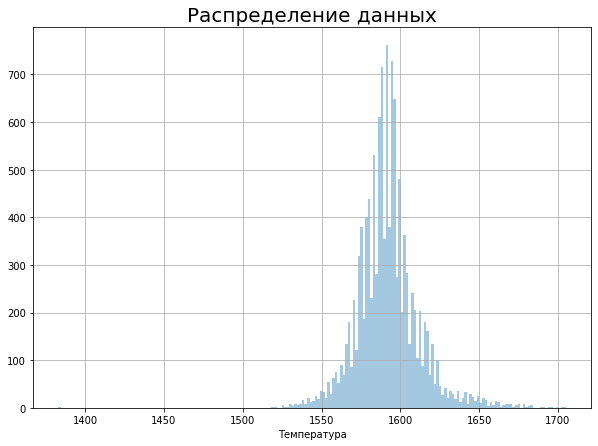

In [35]:
data_temp = data_temp[(data_temp['Температура']>1350) & (data_temp.key<2500)]
sum_info(data_temp)
dist_info(data_temp, 'Температура')

In [36]:
print(f'Пропущенных значений: {data_temp["Температура"].isna().sum()}')

Пропущенных значений: 0


Если в партии не происходит изменения температуры, то такие данные тоже можно считать аномальными. Найдем партии где минимальная и максимальная температуры совпадают, если внутри этих партий нет изменения температуры, удалим эти партии.

In [37]:
table_time = data_temp.groupby(by = 'key')['Температура'].agg(['max','min']).reset_index()
keys_without_temp_change = table_time[table_time['max']==table_time['min']].key.values
data_temp.query('key in @keys_without_temp_change').style.apply(custom_style, axis=None)

,key,Время замера,Температура
1100,195,2019-05-10 14:10:23,1583.000000
1554,279,2019-05-13 23:07:28,1603.000000
3221,632,2019-05-26 16:04:07,1579.000000
3222,632,2019-05-26 16:12:34,1579.000000
3223,632,2019-05-26 16:19:25,1579.000000
11094,2254,2019-07-28 09:48:28,1592.000000
11095,2254,2019-07-28 09:53:52,1592.000000
11359,2312,2019-07-30 09:56:22,1591.000000
11360,2312,2019-07-30 10:06:36,1591.000000


In [38]:
data_temp = data_temp.query('key not in @keys_without_temp_change')

### Выводы /исследовательский анализ/

- Данные об электродах
    - датафрейм(5 столбцов, 14876 строк) содержит информацию о времени начала и конца нагрева дугой, величину активной и реактивной мощности этого нагрева, а также информацию о номере партии.
    - найдена аномалия в значениях реактивной мощности, партия с аномалией удалена.
    - замечена высокая корреляция между активной и реактивной мощностью.
- Данные о подаче сыпучих материалов
    - датафрейм data_bulk(16 столбцов, 3129 строк) содержит информацию об объеме сыпучих материалов поступающих в ковш. Количество возможных материалов 15 - соответствует столбцам Bulk 1 .. Bulk 15, а также информацию о номере партии.
    - датафрейм data_bulk_time(16 столбцов, 3129 строк) содержит информацию о времени поступления сыпучих материалов в ковш. Количество возможных материалов 15 - соответствует столбцам Bulk 1 .. Bulk 15, а также информацию о номере партии.
    - аномалий не обнаружено.
    - пропущенные значения в data_bulk заменены на 0.
- Данные о продувке сплава газом
    - датафрейм(2 столбцов, 3239 строк) содержит информацию об объеме инертного газа, учавствующего в продуве и информацию о номере партии.
    - аномалий и пропусков не обнаружено.
- Данные о проволочных материалах
    -  - датафрейм data_wire(10 столбцов, 3081 строк) содержит информацию об объеме проволочных материалов поступающих в ковш. Количество возможных материалов 9 - соответствует столбцам Wire 1 .. Wire 9, а также информацию о номере партии.
    - датафрейм data_wire_time(10 столбцов, 3081 строк) содержит информацию о времени поступления проволочных материалов в ковш. Количество возможных материалов 9 - соответствует столбцам Wire 1 .. Wire 15, а также информацию о номере партии.
    - аномалий не обнаружено.
    - пропущенные значения в data_wire заменены на 0.
- Данные о температуре
    - датафрейм(3 столбцов, 3239 строк) содержит информацию о времени замера температуры, о величине этого замера и информацию о номере партии.
    - найдены аномальные значения, удалены строки с аномальными значениями.
    - найдены пропуски, удалены партии с пропусками.
    - если температура в партии не меняется со временем - удаляем эти партии. 
- В таблицах разное количество уникальных номеров партии. Это может означать, что в рамках этой партии не выполнялся тот или иной технологический этап. 
- Для дальнейшей работы данные требуют предобработки и группировки по партии.

## Подготовка данных для построения модели.

### Генерация признаков

1. Вычислим полную мощность - full_power
2. Длительность времени между первым замером температуры и последним замером температуры (в секундах) - full_time
3. Суммарное время нагрева электродами (в секундах)- heat_time
4. Среднее соотношение потребления активной и реактивной мощности - mean_ratio_power
5. Подсчет энергии $ Energy = FullPower * time $ - energy
5. Добавим информацию о начальной температуре партии (init_time), о продувке газом (gas), о добавлении сыпучих (bulk) и проволочных (wire) материалов

In [39]:
data_arc['full_power'] = (data_arc['Активная мощность']**2+data_arc['Реактивная мощность']**2)**0.5
data_arc['ratio_power'] = data_arc['Активная мощность']/data_arc['Реактивная мощность']
data_arc['heat_time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).apply(lambda x: x.seconds)
display(data_arc.head(10))
table_power = data_arc.groupby(by = 'key')['full_power', 'ratio_power', 'heat_time', 'Начало нагрева дугой', 'Конец нагрева дугой'].agg(
            {'full_power':'sum', 'ratio_power':'mean', 'heat_time':'sum', 'Начало нагрева дугой': 'min', 'Конец нагрева дугой':'max'}).reset_index()
table_power.rename(columns = {'Начало нагрева дугой': 'init_heat_time', 'Конец нагрева дугой': 'end_heat_time'}, inplace = True)
table_power.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_power,ratio_power,heat_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,1.420582,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,1.548395,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,1.492292,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,1.561504,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,1.671717,148
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549,1.547690,137
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162,1.451893,338
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0.577638,1.606312,126
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0.975867,1.601441,210
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1.256527,1.581626,280


,key,full_power,ratio_power,heat_time,init_heat_time,end_heat_time
0,1,5.826395,1.538898,1098,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,3.649216,1.551834,811,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,2.989534,1.583120,655,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,3.814962,1.563487,741,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,4.035758,1.480428,869,2019-05-03 13:11:13,2019-05-03 13:33:55


In [40]:
table_temp = data_temp.groupby(by = 'key')['Время замера', 'Температура'].agg(
                {'Время замера':['min','max'], 'Температура':['first','last']}).reset_index()
table_temp.columns = table_temp.columns.droplevel(0)
table_temp.columns = ['key','init_time', 'end_time', 'init_temp', 'end_temp']
table_temp.head()

,key,init_time,end_time,init_temp,end_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [41]:
table = table_power.merge(table_temp)
table.head(11)

,key,full_power,ratio_power,heat_time,init_heat_time,end_heat_time,init_time,end_time,init_temp,end_temp
0,1,5.826395,1.538898,1098,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,3.649216,1.551834,811,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2.989534,1.583120,655,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,3.814962,1.563487,741,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,4.035758,1.480428,869,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
5,6,4.786837,1.501854,952,2019-05-03 13:46:51,2019-05-03 14:09:24,2019-05-03 13:49:24,2019-05-03 14:12:29,1543.0,1596.0
6,7,2.987777,1.628748,673,2019-05-03 14:16:46,2019-05-03 14:41:15,2019-05-03 14:19:43,2019-05-03 14:42:37,1586.0,1599.0
7,8,4.627389,1.486391,913,2019-05-03 14:53:56,2019-05-03 15:14:47,2019-05-03 15:07:18,2019-05-03 15:22:52,1577.0,1598.0
8,9,2.555348,1.421598,625,2019-05-03 15:33:42,2019-05-03 15:59:48,2019-05-03 15:37:03,2019-05-03 16:01:16,1587.0,1592.0
9,10,3.851739,1.231654,825,2019-05-03 16:11:08,2019-05-03 16:34:50,2019-05-03 16:14:29,2019-05-03 16:36:08,1574.0,1593.0


В сборной таблице есть партии, в которых последний нагрев идет после измерения конечной температуры. Скорее всего в изначальных данных отсутствует информация о последнем замере(иначе зачем тогда нагревать пустой ковш). Посмотрим сколько таких партий. Если немного, удалим эти партии.

In [42]:
print(f"Количество партий в которых после измерения конечной температуры происходит нагрев дугой: {table.query('end_heat_time > end_time').shape[0]}")

Количество партий в которых после измерения конечной температуры происходит нагрев дугой: 131


In [43]:
table = table.query('end_heat_time <= end_time')

In [44]:
table['full_time'] = (table.end_time- table.init_time).apply(lambda x: x.seconds)
table['energy'] = table.full_power*table.heat_time
table.head()

,key,full_power,ratio_power,heat_time,init_heat_time,end_heat_time,init_time,end_time,init_temp,end_temp,full_time,energy
0,1,5.826395,1.538898,1098,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,861,6397.381637
1,2,3.649216,1.551834,811,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,1305,2959.514496
2,3,2.989534,1.583120,655,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,1300,1958.144876
3,4,3.814962,1.563487,741,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,388,2826.887120
4,5,4.035758,1.480428,869,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,762,3507.073549


In [45]:
table = table[['key', 'init_temp', 'energy', 'ratio_power', 'full_time', 'end_temp']]
table.head()

,key,init_temp,energy,ratio_power,full_time,end_temp
0,1,1571.0,6397.381637,1.538898,861,1613.0
1,2,1581.0,2959.514496,1.551834,1305,1602.0
2,3,1596.0,1958.144876,1.583120,1300,1599.0
3,4,1601.0,2826.887120,1.563487,388,1625.0
4,5,1576.0,3507.073549,1.480428,762,1602.0


Теперь добавим данные о сыпучих и проволочных материалов.

In [46]:
full_table = table.merge(data_bulk).merge(data_wire).merge(data_gas)
display(full_table.head())
full_table.shape

,key,init_temp,energy,ratio_power,full_time,end_temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,1571.0,6397.381637,1.538898,861,1613.0,0,0,0,43,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,2959.514496,1.551834,1305,1602.0,0,0,0,73,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1958.144876,1.583120,1300,1599.0,0,0,0,34,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,2826.887120,1.563487,388,1625.0,0,0,0,81,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,3507.073549,1.480428,762,1602.0,0,0,0,78,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


(2206, 31)

In [47]:
full_table.drop('key', axis = 1, inplace = True)
full_table.head()

,init_temp,energy,ratio_power,full_time,end_temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1571.0,6397.381637,1.538898,861,1613.0,0,0,0,43,0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,1581.0,2959.514496,1.551834,1305,1602.0,0,0,0,73,0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1596.0,1958.144876,1.583120,1300,1599.0,0,0,0,34,0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,1601.0,2826.887120,1.563487,388,1625.0,0,0,0,81,0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,1576.0,3507.073549,1.480428,762,1602.0,0,0,0,78,0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


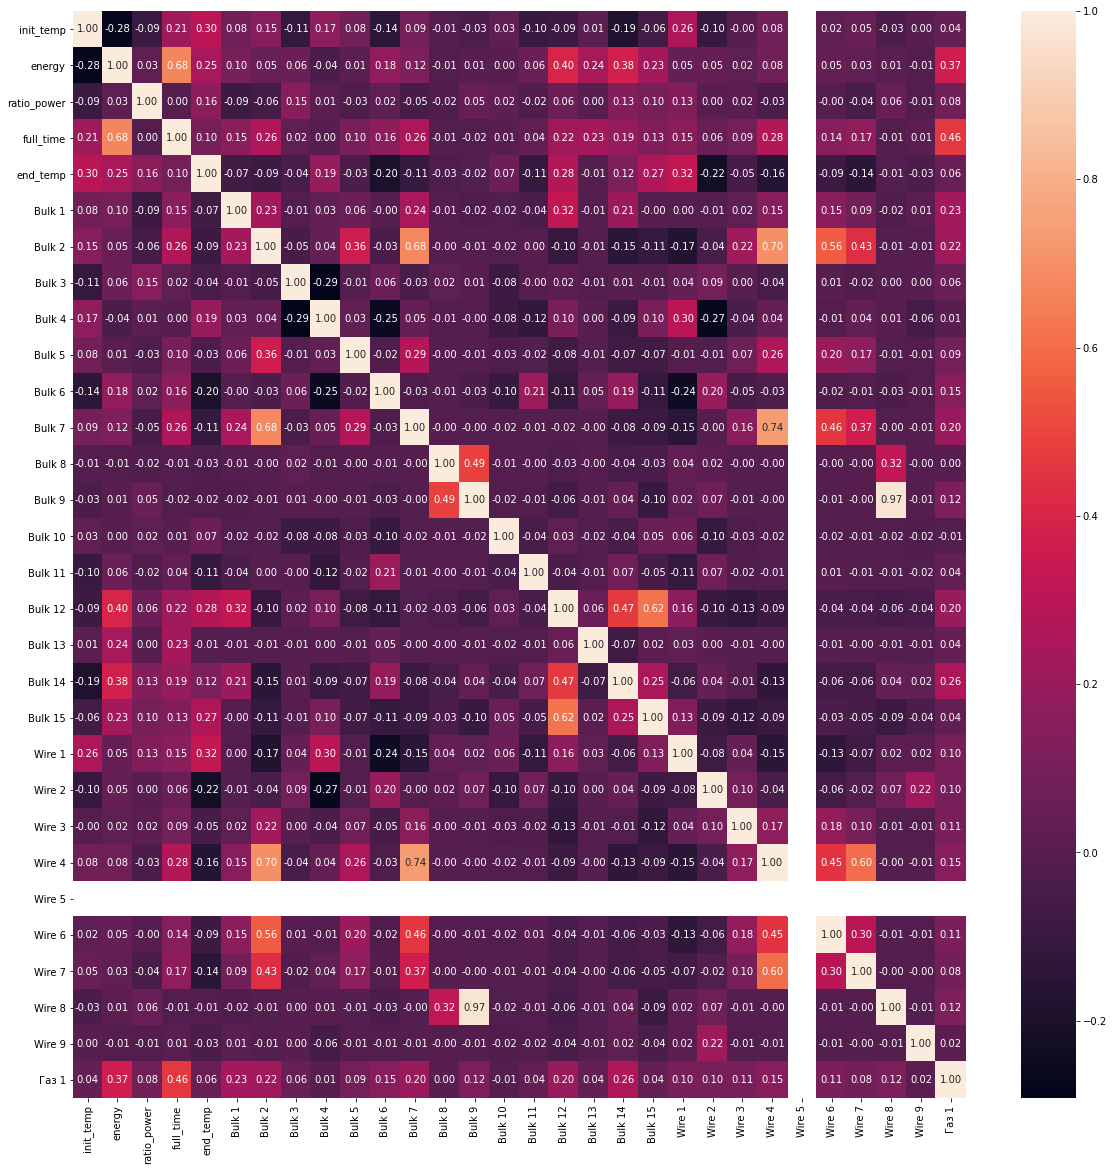

In [48]:
plt.figure(figsize=(20,20))
sns.heatmap(full_table.corr(), annot=True, fmt='.2f')
plt.show()

Видим аномальную корреляцию Wire 5 с остальными столбцами - это столбец с нулями(этот материал не добавлялся в наших партиях). Удалим этот признак.

Еще видим высокую корреляцию между столбцами Wire 8 - Bulk 9. Пока оставим эти столбцы, это тоже может быть обусловлено малым количеством данных по этим столбцам. И с точки зрения физического смысла, мне кажется, лучше оставлять все добавки.

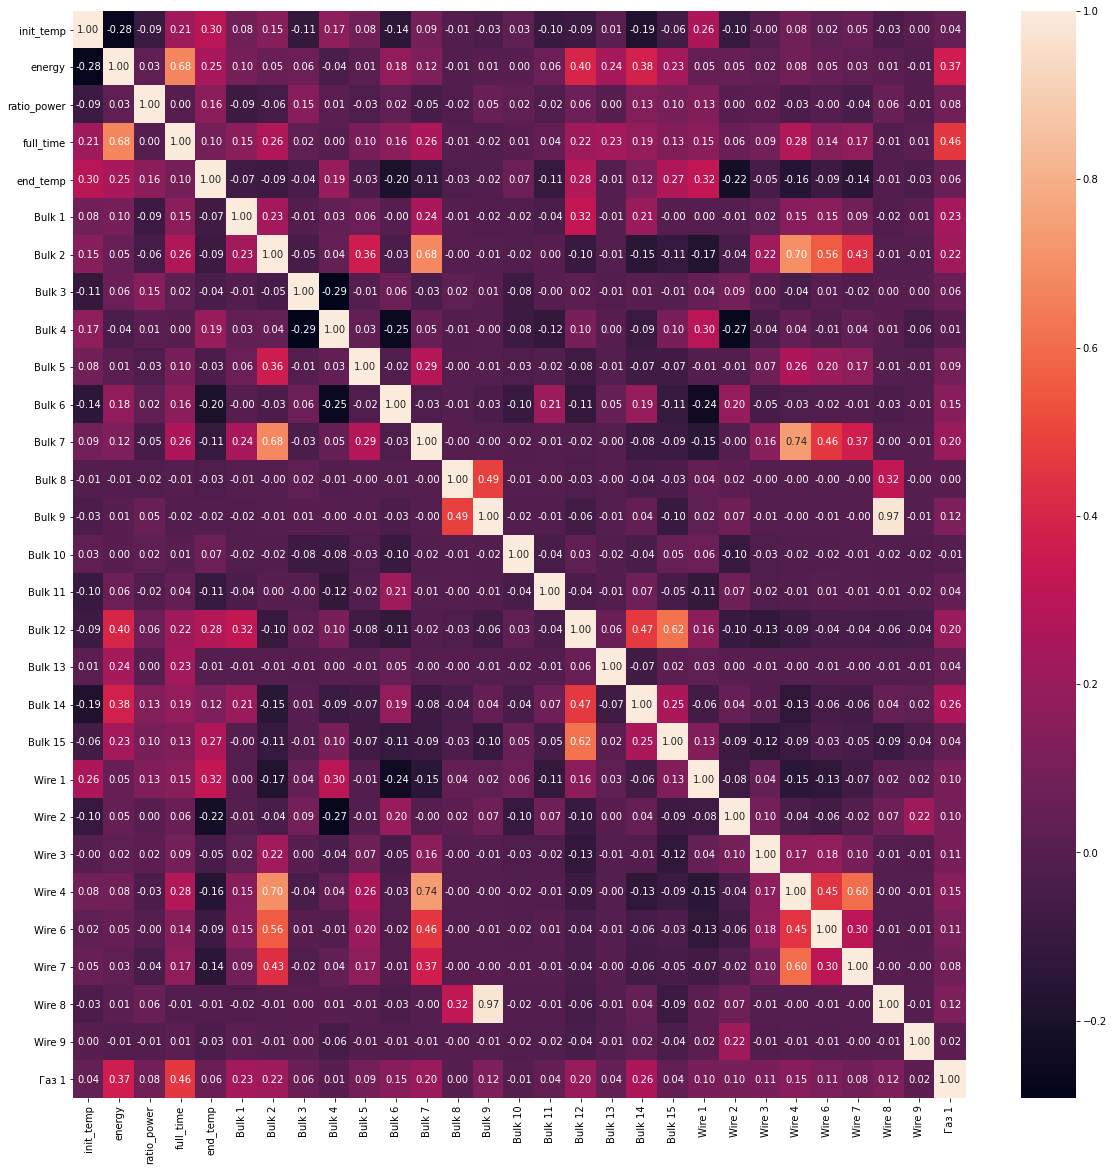

In [49]:
full_table.drop(['Wire 5'], axis = 1, inplace = True)
plt.figure(figsize=(20,20))
sns.heatmap(full_table.corr(), annot=True, fmt='.2f')
plt.show()

## Построение моделей

In [50]:
random_state = 20220809
features = full_table.drop('end_temp', axis=1)
target = full_table['end_temp']
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(1654, 28) (1654,)
(552, 28) (552,)


In [51]:
def model(model_name, parameters, features = features_train):
    model = GridSearchCV(model_name, param_grid=parameters, scoring='neg_mean_absolute_error', cv=5) 
    model.fit(features_train, target_train) 
    print('Модель:', model.best_estimator_)
    print('Параметры модели: ', model.best_params_)
    print('MAE = ', (model.best_score_*-1))
    return model.best_estimator_

### Linear Regression

In [52]:
%%time

ss = StandardScaler() #normalize data
features_train_scaled = ss.fit_transform(features_train)
features_test_scaled = ss.transform(features_test)
model_LR = LinearRegression()
model_LR.fit(features_train, target_train) 
score_LR = (cross_val_score(model_LR,
                            features_train, 
                            target_train, 
                            cv=5, 
                            scoring='neg_mean_absolute_error').mean() * -1)
print('MAE =', score_LR)

MAE = 6.350226370372764
CPU times: user 252 ms, sys: 781 ms, total: 1.03 s
Wall time: 967 ms


### Random Forest Regressor

In [53]:
%%time

params_RF = {'min_samples_leaf': [2,3,4,5], 
             'n_estimators':[100, 500, 1000]} 
model_RF = model(RandomForestRegressor(random_state = random_state, n_jobs=-1), params_RF)

Модель: RandomForestRegressor(min_samples_leaf=3, n_estimators=1000, n_jobs=-1,
                      random_state=20220809)
Параметры модели:  {'min_samples_leaf': 3, 'n_estimators': 1000}
MAE =  5.95533520789334
CPU times: user 3min 29s, sys: 731 ms, total: 3min 30s
Wall time: 3min 30s


### CatBoost Regressor

In [867]:
%%time

params_CB = {'iterations': [100, 500, 800],
             'depth': [3, 5, 7],
             'learning_rate': [0.01, 0.1, 0.3],
            'l2_leaf_reg': [3, 5, 7]
            }
model_CB = model(CatBoostRegressor(random_state=random_state, verbose = 0), params_CB)

Модель: <catboost.core.CatBoostRegressor object at 0x000001DC1F85BF48>
Параметры модели:  {'depth': 5, 'iterations': 500, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
MAE =  5.556405876596429
Wall time: 5min


### LightGBM Regressor

In [868]:
%%time

params_LGBM = {'num_leaves': [3, 5, 7],
          'learning_rate': [0.01, 0.1, 0.3],
          'max_depth': [3, 5, 10],
          'n_estimators': [500, 700, 1000],
          'objective':['mae']}
model_LGBM = model(LGBMRegressor(random_state=random_state), params_LGBM)

Модель: LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=3, objective='mae',
              random_state=20220809, reg_alpha=0.0, reg_lambda=0.0,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
Параметры модели:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500, 'num_leaves': 3, 'objective': 'mae'}
MAE =  5.675566764355123
Wall time: 54.6 s


### Оценка важности признаков, корректировки моделей

Посмотрим какие признаки являются самыми важными для построенных моделей. Для этого используем feature_importances_ для моделей CB, LGBM и RF. Чтобы сравнивать важность признаков для разных моделей  - нормализуем их.

Для линейной регрессии для отбора признаков используем L1 регуляризацию.

In [869]:
def f_importance(model):
    """function that calculate features importance
    input: model
    output: table of feature importance 
    """
    feats = {feature:importance for feature, importance in zip(full_table.drop('end_temp', axis = 1).columns, model.feature_importances_)}
    importances = pd.DataFrame(feats.items(), columns = ['features', 'importance']).sort_values(by = 'importance', ascending = False)
    importances['importance'] = importances.importance/importances.importance.max() #normalize feature importance
    return importances
            
def display_side_by_side(dfs:list, captions:list):
    """display tables side by side to save vertical space
    input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption).bar('importance').hide_index()._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

display_side_by_side([f_importance(model_RF), f_importance(model_CB), f_importance(model_LGBM)],
                     [type(model_RF).__name__, type(model_CB).__name__, type(model_LGBM).__name__])

features,importance
energy,1
init_temp,0.976439
Wire 1,0.462235
full_time,0.372739
Bulk 6,0.292817
ratio_power,0.249712
Wire 2,0.191101
Газ 1,0.181536
Bulk 14,0.169377
Bulk 15,0.158287


In [870]:
model_L = Lasso(alpha = 0.1, max_iter = 500, random_state = random_state)
model_L.fit(features_train_scaled, target_train) 
score_L = (cross_val_score(model_L,
                            features_train_scaled, 
                            target_train, 
                            cv=5, 
                            scoring='neg_mean_absolute_error').mean() * -1)
print('MAE =', score_L)
print(f'Признаки удаленные с помощью L1 регуляризации: {[features.columns[i] for i in range(len(list(model_L.coef_))) if list(model_L.coef_)[i]==0]}')

MAE = 6.262265911354948
Признаки удаленные с помощью L1 регуляризации: ['Bulk 5', 'Bulk 9', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 8', 'Газ 1']


Как мы видим из таблиц важности признаков и из признаков удаленных благодаря L1 регуляризации, "неважные" признаки это некоторые сыпучие или проволочные добавки или объем газа для продува. Посмотрим, как изменяться наши модели при удалении самых неважных признаков.

- для Линейной регрессии уже метрика посчитана выше. MAE при L1 регуляризации примерно такое же, что и без нее.
- для остальных моделей уберем все признаки, важность которых меньше 0.001

In [871]:
def f_select(importances):
    not_need = list(importances.query('importance<0.001').features.values)
    return features_train.drop(not_need, axis=1)

importances_CB = f_importance(model_CB)
importances_RF = f_importance(model_RF)
importances_LGBM = f_importance(model_LGBM)

In [872]:
%%time

model_RF = model(RandomForestRegressor(random_state=random_state), params_RF, f_select(importances_RF))

Модель: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=20220809,
                      verbose=0, warm_start=False)
Параметры модели:  {'min_samples_leaf': 3, 'n_estimators': 1000}
MAE =  5.955224322576829
Wall time: 2min 58s


In [873]:
%%time

model_CB = model(CatBoostRegressor(random_state=random_state, verbose = 0), params_CB, f_select(importances_CB))

Модель: <catboost.core.CatBoostRegressor object at 0x000001DC19F45C88>
Параметры модели:  {'depth': 5, 'iterations': 500, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
MAE =  5.556405876596429
Wall time: 4min 35s


In [874]:
%%time

model_LGBM = model(LGBMRegressor(random_state=random_state), params_LGBM, f_select(importances_LGBM))

Модель: LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=3, objective='mae',
              random_state=20220809, reg_alpha=0.0, reg_lambda=0.0,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
Параметры модели:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500, 'num_leaves': 3, 'objective': 'mae'}
MAE =  5.675566764355123
Wall time: 51.5 s


- качество Линейной регрессии с L1 регуляризацией немного улучшилось.
- качество остальных моделей не изменилось после удаления "неважных" признаков
- время работы(подбор гиперпараметров) изменилось только у RandomForest

Поскольку качество лучших моделей и не изменилось, а также, важность этих признаков может быть обусловлена физическим смыслом, считаю, что оставить нужно все имеющиеся признаки. (мне кажется, модели не считают эти признаки важными, потому что эти материалы добавляли очень редко и в данных очень много нулей)

### Тестирование и сравнение моделей

Итак, мы определили гиперпараметры и качество модели на кросс-валидации.

Теперь протестируем лучшие модели на тестовой выборке и проведем их проверку на адекватность(с помощью DummyRegressor).



In [54]:
start = time.time()

DR = DummyRegressor(strategy="median")
DR.fit(features_train, target_train)
predict_DR= DR.predict(features_test)
score_dummy = mean_absolute_error(target_test, predict_DR)
print('MAE Dummy регрессора =', score_dummy)
dict_DR = {'Dummy Regressor': score_dummy}

end = time.time()
time_DR = end - start
print('Wall time', time_DR)

MAE Dummy регрессора = 7.690217391304348
Wall time 0.00269317626953125


In [55]:
def test_model(model):
    """function that checks the model on the test set
    input: model 
    output: dictionary with name of the model and its MAE score"""
    model = model
    model.fit(features_train, target_train)
    predicted = model.predict(features_test)
    score = mean_absolute_error(target_test, predicted)
    print(model)
    print('MAE = ', score)
    dict_model_score = {type(model).__name__:score}
    return dict_model_score

In [56]:
start = time.time()

dict_LR = test_model(model_LR)

end = time.time()
time_LR = end - start
print('Wall time', time_LR)

LinearRegression()
MAE =  5.576986802871027
Wall time 0.07217931747436523


In [57]:
start = time.time()

dict_RF = test_model(model_RF)

end = time.time()
time_RF = end - start
print('Wall time', time_RF)

RandomForestRegressor(min_samples_leaf=3, n_estimators=1000, n_jobs=-1,
                      random_state=20220809)
MAE =  5.458925020044058
Wall time 7.915552139282227


In [ ]:
start = time.time()

dict_CB = test_model(model_CB)

end = time.time()
time_CB = end - start
print('Wall time', time_CB)

In [880]:
start = time.time()

dict_LGBM = test_model(model_LGBM)

end = time.time()
time_LGBM = end - start
print('Wall time', time_LGBM)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=3, objective='mae',
              random_state=20220809, reg_alpha=0.0, reg_lambda=0.0,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
MAE =  5.238997230377332
Wall time 0.08101630210876465


In [881]:
dict_time = {'Dummy Regressor': time_DR, 'LinearRegression': time_LR, 'RandomForestRegressor': time_RF, 
             'CatBoostRegressor': time_CB, 'LGBMRegressor': time_LGBM}
dict_scores = {**dict_DR, **dict_LR, **dict_RF, **dict_CB, **dict_LGBM}
table_scores = pd.DataFrame(dict_scores, index = ['MAE score']).T.reset_index()
table_time = pd.DataFrame(dict_time, index = ['time(sec)']).T.reset_index()
comparison_table = table_scores.merge(table_time, how = 'outer')
comparison_table.rename(columns = {'index':'model'}, inplace = True)
comparison_table

,model,MAE score,time(sec)
0,Dummy Regressor,7.690217,0.003001
1,LinearRegression,5.576987,0.008481
2,RandomForestRegressor,5.458925,7.017410
3,CatBoostRegressor,5.313541,0.618216
4,LGBMRegressor,5.238997,0.081016


### Выводы /Построение модели/

- Подготовлены признаки. Составлена таблица со всеми данными для модели, включающая целевой признак - последняя замеренная температура партии. 
- Разделены на features и target (75%/25%).
- Выбраны модели. Выбраны гиперпараметры для моделей с помощью GridSearch
- Проведена оценка важностей составленных признаков. Приведены соображения почему количество признаков не нуждается в корректировке.
- Оценена эффективность моделей и время обучения на тестовой выборке. 
- Все модели показали достойные варианты метрики.
- Лучшей моделью по метрике MAE стал LightGBM регрессор. Этот результат показывает, что модель в среднем ошибается (в предсказании температуры) на 5.24 градусов.

### Замечания

Хотелось бы дать некоторые рекомендации при сборе информации. Необходим четкий контроль измерения начальной температуры до проведения каких-либо манипуляций со сталью (нагрев или добавление материалов) и контроль измерения конечной температуры после проведения всех манипуляций. 

## Отчет

**РАЗРАБОТКА МОДЕЛИ ПРЕДСКАЗЫВАЮЩЕЙ ТЕМПЕРАТУРУ СПЛАВА**

Для оптимозации производственных расходов металлургического комбината ООО "Так закаляем сталь" была поставлена задача уменьшения потребления электроэнергии на этапе обработки стали. В рамках этих мероприятий была разработана модель предсказывающая конечную температуру стали в ковше(температуру перед отправлением стали в машину непрерывной разливки).

На начальном этапе был составлен план проекта:
1. Разбор производственного процесса;
2. Изучение данных;
3. Исследовательский анализ данных;
4. Подготовка данных для построения модели, генерация признаков, проверка на мультиколлинеарность;
5. Построение и обучение моделей, выбор гиперпараметров;
6. Корректировка признаков, обучение моделей;
7. Тестирование и оценка эффективности модели;
8. Выводы.

Результаты по каждому пункту плана:
1. В соответствии с производственным процессом конечная температура зависит от различных факторов, таких как начальная температура стали, добавление легирующих материалов, продувка инертным газом, от мощности нагрева ковша. Необходимо подготовить признаки для модели основываясь на физике производственного процесса.
2. Данные, используемые для этого анализа были предоставлены заказчиком:
    - данные об электродах(время начала и конеца нагрева, активная и реактивная мощности нагрева)
    - данные о подаче сыпучих и проволочных материалов(их объем и время подачи)
    - данные о продувке сплава газом
    - результаты замеров температуры(величина замера в градусах и время проведения замера)
    - во всех данных есть информация о номере партии, в которой проходили замеры.
    - данные предоставлены в виде csv-файлов.
3. Исследовательский анализ.
    EDA был проведен для определения качества данных: поиск особенностей, аномалий и проверка адекватности. Было сделано:
    - приведение данных к подходяцему типу(время - timestamp, целые числа - int)
    - удаление партий, содержащих аномальные значения мощности
    - замена пропущенных значений в данных о легирующих добавках на 0
    - удалены строки, содержащие аномальные значения температуры
    - замечено, что в предоставленных таблицах разное количество уникальных номеров партии.
    - для дальнейшей работы данные требуют предобработки и группировки по партии. 
4. Подготовка данных для построения модели.
    Мною были сгенерированы следующие признаки:
    - Энергия потраченная на нагрев дуги $ Energy = FullPower * time, $ где $FullPower = \sqrt{P^2 + Q^2},$ $P$ - активная мощность, $Q$ - реактивная мощность. (`energy`)
    - Длительность времени между первым замером температуры и последним замером температуры (в секундах) (`full_time`)
    - Среднее соотношение потребления активной и реактивной мощности (`mean_ratio_power`)
    - Начальная температура партии (`init_time`)
    - Объем газа при продувке сплава ('gas')
    - Объем добавленых сыпучих (`bulk_i`, i=1..15) и проволочных (`wire_i`, i= 1..9) материалов